In [1]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [2]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

### Import

In [16]:
methods= ["direct_and_pr", "iterative_pr_head_ref_cherry_picked"]

In [17]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [20]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [21]:
methods_df = {"direct_and_pr":direct_and_pr,
             "iterative_pr_head_ref_cherry_picked": iterative_pr_head_ref_cherry_picked}

**Extracting the dependent variables** 

In [22]:
dep_var_cols = ["post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [23]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]

**Extracting the independent variables**

In [24]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag']

In [30]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [31]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)

### Missing values

In [32]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [33]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [34]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,min_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs2_burst_size_min,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,1146.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,11.000000,11.0,11,11,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [35]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [36]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [38]:
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 235)
iterative_pr_head_ref_cherry_picked (52, 214)


### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [39]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    methods_pearson_corr_post_release_bugs[method] = methods_indep_var[method]\
                                            .corrwith(corr_col)
    methods_spearman_corr_post_release_bugs[method] = methods_indep_var[method]\
                                            .corrwith(corr_col, method="spearman")

**Method 0 correlation analysis**

In [40]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(30)

max_n_builds_per_pull_request         0.497782
canceled_gp1_bs3_n_bursts_max         0.478835
not_passed_gp1_bs3_n_bursts_max       0.478835
failed_gp1_bs3_n_bursts_max           0.478835
failed_gp3_bs3_burst_size_mean        0.478759
not_passed_gp3_bs3_burst_size_mean    0.478759
canceled_gp3_bs3_burst_size_mean      0.478759
failed_gp1_bs1_n_bursts_max           0.478402
not_passed_gp1_bs1_n_bursts_max       0.478402
canceled_gp1_bs1_n_bursts_max         0.478402
canceled_gp2_bs1_n_bursts_max         0.477622
failed_gp2_bs1_n_bursts_max           0.477622
not_passed_gp2_bs1_n_bursts_max       0.477622
canceled_gp3_bs3_n_bursts_max         0.476412
failed_gp3_bs3_n_bursts_max           0.476412
not_passed_gp3_bs3_n_bursts_max       0.476412
canceled_gp3_bs1_n_bursts_max         0.472924
failed_gp3_bs1_n_bursts_max           0.472924
not_passed_gp3_bs1_n_bursts_max       0.472924
failed_gp3_bs3_burst_size_max         0.470321
canceled_gp3_bs3_burst_size_max       0.470321
not_passed_gp

In [41]:
df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(30)

max_failed_tests                     0.623745
max_n_builds_per_pull_request        0.580333
canceled_gp1_bs2_n_bursts_max        0.555715
failed_gp1_bs2_n_bursts_max          0.555715
not_passed_gp1_bs2_n_bursts_max      0.555715
failed_gp3_bs3_n_bursts_max          0.548103
not_passed_gp3_bs3_n_bursts_max      0.548103
canceled_gp3_bs3_n_bursts_max        0.548103
mean_failed_tests                    0.547461
canceled_gp3_bs3_burst_size_max      0.542991
failed_gp3_bs3_burst_size_max        0.542991
not_passed_gp3_bs3_burst_size_max    0.542991
canceled_gp3_bs1_n_bursts_max        0.535033
failed_gp3_bs1_n_bursts_max          0.535033
not_passed_gp3_bs1_n_bursts_max      0.535033
canceled_gp1_bs3_n_bursts_max        0.525630
not_passed_gp1_bs3_n_bursts_max      0.525630
failed_gp1_bs3_n_bursts_max          0.525630
not_passed_gp2_bs3_n_bursts_max      0.524151
failed_gp2_bs3_n_bursts_max          0.524151
canceled_gp2_bs3_n_bursts_max        0.524151
canceled_gp2_bs2_n_bursts_max     

<AxesSubplot:>

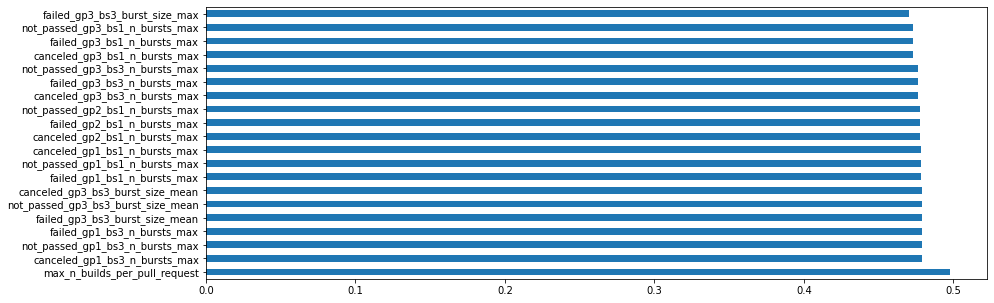

In [42]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

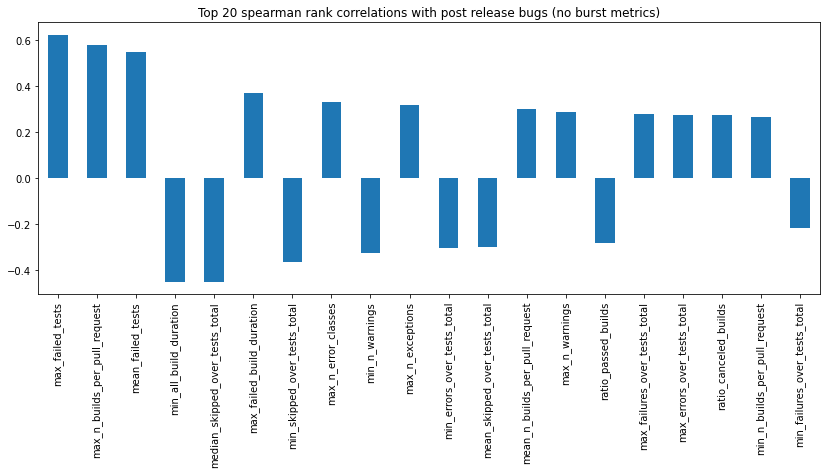

In [43]:
df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='max_n_builds_per_pull_request', ylabel='post_release_bugs'>

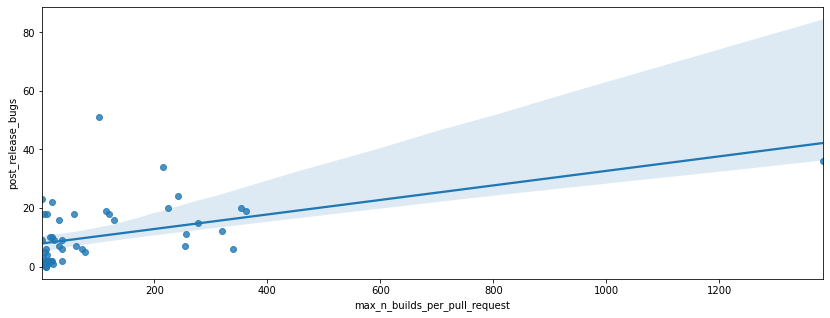

In [44]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
sns.regplot(df_ind.max_n_builds_per_pull_request, df_dep.post_release_bugs)

**Method 1 correlation analysis**

In [45]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(30)

canceled_gp2_bs3_burst_size_max       0.488292
failed_gp2_bs3_burst_size_max         0.488292
not_passed_gp2_bs3_burst_size_max     0.488292
not_passed_gp2_bs2_burst_size_max     0.485160
failed_gp2_bs2_burst_size_max         0.485160
canceled_gp2_bs2_burst_size_max       0.485160
not_passed_gp2_bs1_burst_size_max     0.484351
failed_gp2_bs1_burst_size_max         0.484351
canceled_gp2_bs1_burst_size_max       0.484351
canceled_gp3_bs3_burst_size_mean      0.441076
failed_gp3_bs3_burst_size_mean        0.441076
not_passed_gp3_bs3_burst_size_mean    0.441076
ratio_passed_builds                  -0.429787
canceled_gp3_bs3_burst_size_max       0.417021
failed_gp3_bs3_burst_size_max         0.417021
not_passed_gp3_bs3_burst_size_max     0.417021
not_passed_gp3_bs2_burst_size_max     0.413592
failed_gp3_bs2_burst_size_max         0.413592
canceled_gp3_bs2_burst_size_max       0.413592
not_passed_gp3_bs1_burst_size_max     0.412172
failed_gp3_bs1_burst_size_max         0.412172
canceled_gp3_

In [46]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(30)

max_failed_tests                     0.604831
max_n_builds_per_pull_request        0.581404
mean_failed_tests                    0.553903
canceled_gp1_bs2_n_bursts_max        0.550107
not_passed_gp1_bs2_n_bursts_max      0.550107
failed_gp1_bs2_n_bursts_max          0.550107
canceled_gp3_bs1_n_bursts_max        0.528155
failed_gp3_bs1_n_bursts_max          0.528155
not_passed_gp3_bs1_n_bursts_max      0.528155
not_passed_gp2_bs2_n_bursts_max      0.511154
canceled_gp2_bs2_n_bursts_max        0.511154
failed_gp2_bs2_n_bursts_max          0.511154
failed_gp1_bs1_n_bursts_max          0.497198
not_passed_gp1_bs1_n_bursts_max      0.497198
canceled_gp1_bs1_n_bursts_max        0.497198
canceled_gp3_bs3_n_bursts_max        0.496669
failed_gp3_bs3_n_bursts_max          0.496669
not_passed_gp3_bs3_n_bursts_max      0.496669
not_passed_gp2_bs3_n_bursts_max      0.496523
failed_gp2_bs3_n_bursts_max          0.496523
canceled_gp2_bs3_n_bursts_max        0.496523
not_passed_gp1_bs3_n_bursts_max   

<AxesSubplot:>

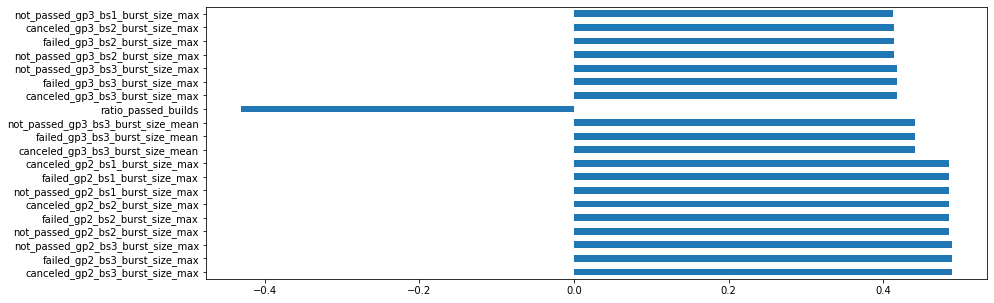

In [47]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

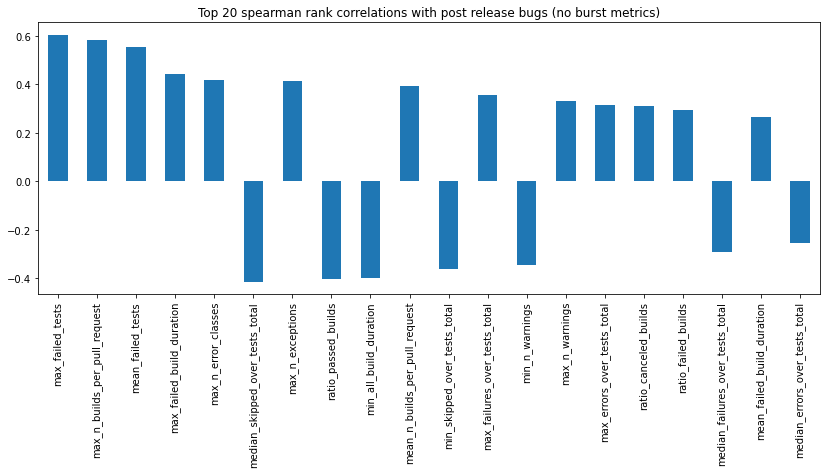

In [48]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='canceled_gp2_bs3_burst_size_max', ylabel='post_release_bugs'>

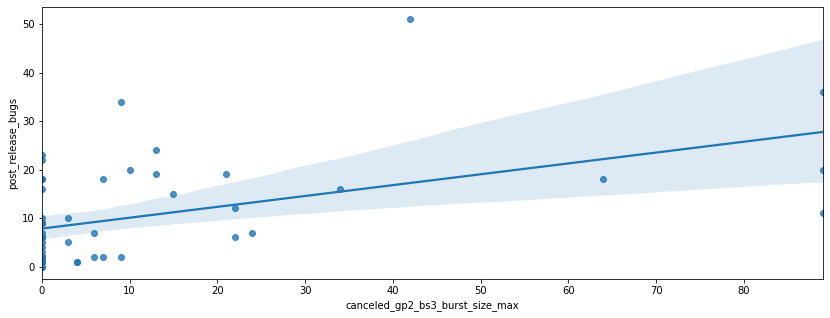

In [49]:
df_ind = methods_indep_var[methods[1]]
df_dep = methods_dep_var[methods[1]]
sns.regplot(df_ind.canceled_gp2_bs3_burst_size_max, df_dep.post_release_bugs)

### Correlation among features

In [50]:
corr_matrix = methods_indep_var[methods[0]].corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
cols_to_remove = [pairs[1] for pairs in sol[sol == 1].index]

In [51]:
len(set(cols_to_remove))

137

In [52]:
corr_matrix = methods_indep_var[methods[0]].drop(columns=cols_to_remove).corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

In [53]:
sol

not_passed_gp2_bs2_burst_size_mean  canceled_gp2_bs2_burst_size_mean     1.000000
not_passed_gp1_bs3_n_bursts_mean    not_passed_gp2_bs3_n_bursts_mean     0.999750
not_passed_gp3_bs1_burst_size_max   not_passed_gp3_bs2_burst_size_max    0.999523
not_passed_gp2_bs1_burst_size_max   not_passed_gp2_bs2_burst_size_max    0.999521
not_passed_gp1_bs1_burst_size_max   not_passed_gp1_bs2_burst_size_max    0.999513
                                                                           ...   
not_passed_gp1_bs2_n_bursts_median  not_passed_gp1_bs3_n_bursts_max      0.000213
median_all_build_duration           not_passed_gp1_bs3_n_bursts_max      0.000150
max_failed_build_duration           mean_n_warnings                      0.000140
max_all_build_duration              not_passed_gp3_bs2_n_bursts_mean     0.000118
not_passed_gp2_bs1_n_bursts_max     not_passed_gp3_bs2_n_bursts_mean     0.000093
Length: 4753, dtype: float64